In [1]:
import pandas as pd

data = pd.read_csv('lemmatized_data.csv')


In [2]:
bg = ' '.join(data['BACKGROUND TO THE APPEAL'])
jg = ' '.join(data['JUDGMENT'])


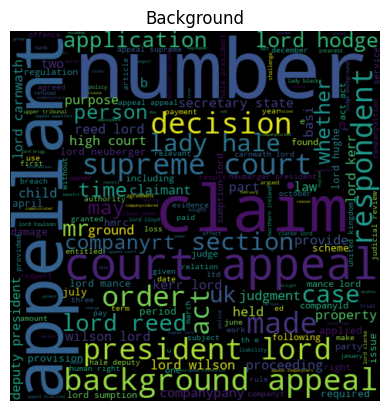

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width = 480, height = 480, margin = 0).generate(bg)

plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.margins(x=0, y= 0)
plt.title("Background")  
plt.show()


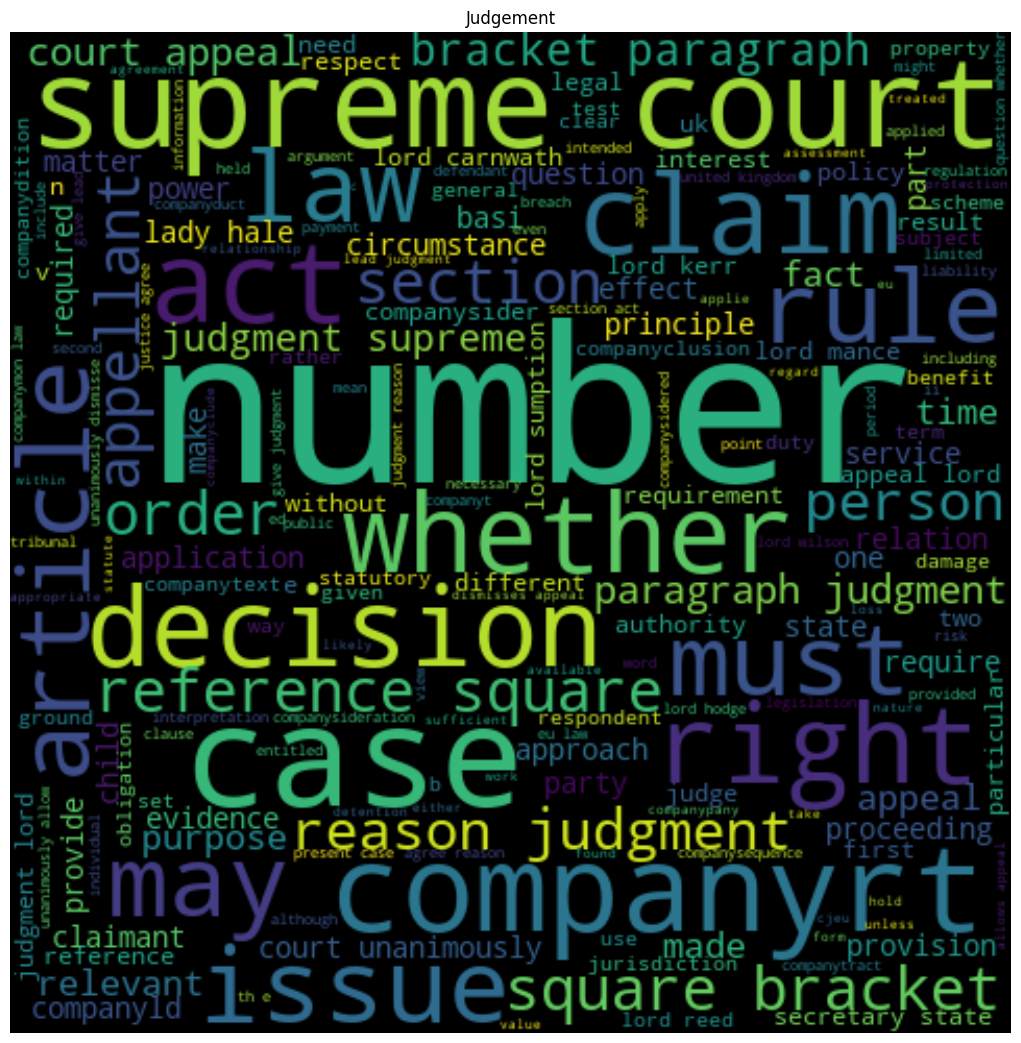

In [4]:
wc2 = WordCloud(width = 480, height = 480, margin = 0).generate(jg)
plt.figure(figsize=(13,13))
plt.imshow(wc2, interpolation = 'bilinear')
plt.axis("off")
plt.margins(x=0, y= 0)
plt.title("Judgement")
plt.show()

In [5]:
import pandas as pd

# Load your data
data = pd.read_csv('lemmatized_data.csv')

# Count the number of unique labels in the 'JUDGMENT' column
num_labels = len(data['JUDGMENT'].unique())

print("Number of unique labels:", num_labels)


Number of unique labels: 318


In [6]:
import pandas as pd
import plotly.express as px
from collections import Counter

word_list = bg.split()
counts = Counter(word_list)

labels, values = zip(*counts.items())

# Create DataFrame
df = pd.DataFrame({'Labels': labels, 'Values': values})

# Sort DataFrame in descending order and get top 20
df = df.sort_values('Values', ascending=False).head(20)

# Create bar chart with specified color
fig = px.bar(df, x='Labels', y='Values', color='Values')

fig.update_layout(
    title={
        'text': "Background",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Show plot
fig.show()


In [7]:
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

stop_words = set(stopwords.words('english'))

word_tokens = word_tokenize(jg)

filtered_text = [w for w in word_tokens if not w in stop_words]

counts = Counter(filtered_text)

# Get the 20 most common words
labels, sizes = zip(*counts.most_common(20))

# Create DataFrame
df = pd.DataFrame({'Labels': labels, 'Sizes': sizes})

# Create pie chart
fig = px.pie(df, values='Sizes', names='Labels')

# Add title
fig.update_layout(
    title={
        'text': "Top 20 Words in Judgement",
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Show plot
fig.show()



In [8]:
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import numpy as np
import networkx as nx

# Create a CountVectorizer object
vectorizer = CountVectorizer(stop_words='english')

# Generate word frequency matrix
X = vectorizer.fit_transform(data['BACKGROUND TO THE APPEAL'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum up the counts of each vocabulary word
dist = np.sum(X, axis=0).A1  # Convert matrix to 1-D array

# Create a frequency dictionary
freq_dict = dict(zip(feature_names, dist))

# Get the top 20 words
top_words = dict(Counter(freq_dict).most_common(20))

# Generate word co-occurrence matrix for top words
vectorizer_top = CountVectorizer(vocabulary=top_words.keys(), stop_words='english')
X_top = vectorizer_top.fit_transform(data['BACKGROUND TO THE APPEAL'])

# Create a co-occurrence matrix
co_occurrence_matrix = (X_top.T * X_top)
co_occurrence_matrix.setdiag(0)

# Create network graph
G = nx.Graph()

# Iterate over the nonzero elements
cx = co_occurrence_matrix.tocoo()
for i,j,v in zip(cx.row, cx.col, cx.data):
    G.add_edge(vectorizer_top.get_feature_names_out()[i], vectorizer_top.get_feature_names_out()[j], weight=v)

# Define positions of nodes
pos = nx.spring_layout(G, seed=42)

# Update node positions
for node in G.nodes():
    G.nodes[node]['pos'] = list(pos[node])

# Create edge trace
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Create node trace
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Color node points by the number of connections.
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = f'{node} # of connections: {len(adjacencies[1])}'
    node_trace['text']+=tuple([node_info])

# Create network graph
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()


In [9]:
import json
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Custom JSONEncoder to handle complex numbers and pandas DataFrames
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, complex):
            return [obj.real, obj.imag]
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict()
        return json.JSONEncoder.default(self, obj)

# Join the tokenized texts
data['BACKGROUND TO THE APPEAL'] = data['BACKGROUND TO THE APPEAL'].apply(' '.join)

# Tokenize the text
data['BACKGROUND TO THE APPEAL'] = data['BACKGROUND TO THE APPEAL'].apply(lambda x: x.split())

# Create a Gensim dictionary from the tokenized texts
dictionary = corpora.Dictionary(data['BACKGROUND TO THE APPEAL'])

# Create a Gensim corpus from the texts
corpus = [dictionary.doc2bow(text) for text in data['BACKGROUND TO THE APPEAL']]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=320, id2word=dictionary)

# Prepare the visualization data
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Convert the PreparedData object to JSON using the custom encoder
vis_JSON = json.dumps(vis_data, cls=CustomEncoder)

# Enable notebook mode for pyLDAvis
pyLDAvis.enable_notebook()

# Display the visualization
pyLDAvis.display(vis_data)

# Save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda.html')


TypeError: Object of type complex is not JSON serializable

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, PegasusTokenizer, PegasusForConditionalGeneration
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Load your data
df = pd.read_csv('lemmatized_data.csv')
train_df, test_df = train_test_split(df, test_size=0.2)

# Define your models and tokenizers
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

pegasus_model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

# LSTM model would need to be defined here. It's a bit more complex because you would need to handle the embeddings and output layers.

# Define your training loop
def train(model, tokenizer, train_df, epochs=10):
    # Define your loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters())

    # Convert your dataframe into a format suitable for training
    # This will depend on your specific use case and data
    # For simplicity, let's assume your dataframe has two columns - 'input' and 'target'
    inputs = tokenizer(train_df['input'].tolist(), return_tensors='pt', truncation=True, padding=True, max_length=512)
    targets = tokenizer(train_df['target'].tolist(), return_tensors='pt', truncation=True, padding=True, max_length=512)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**inputs, labels=targets['input_ids'])
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Train your models
train(t5_model, t5_tokenizer, train_df)
train(pegasus_model, pegasus_tokenizer, train_df)
# train(lstm_model, lstm_tokenizer, train_df)  # Once you've defined your LSTM model and tokenizer

# Now you can compare the performance of each model on your test set.


ModuleNotFoundError: No module named 'transformers.utils'